# Exploring Seattle Pet Licenses

In [1]:
# Load Packages
from pprint import pprint # For tidy printing
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path # For storing filepaths as a Path Object

# Load Packages (API Pulls)
import requests
from io import StringIO
import time # To record elapsed time

# Assess Directories
# Path.home() # Profile root directory
Path.cwd() # https://realpython.com/python-pathlib/
# Path('c:/Users/tbonn/Code/Python/Local/Data_Nash/Excel_File').parent # Parent directory of the string

# Create Data Filepath (this data was originally exported and manually saved as an .xlsx file)
# data_filepath = Path.cwd() / 'Data' / 'Seattle_Pet_Licenses.xlsx' # / pastes filepaths together
data_filepath = Path(r'C:\Users\tbonn\Code\Python\Local\Data_Nash\Excel_File\Data\Seattle_Pet_Licenses.xlsx'); pprint(data_filepath)


WindowsPath('C:/Users/tbonn/Code/Python/Local/Data_Nash/Excel_File/Data/Seattle_Pet_Licenses.xlsx')


## Read in the Data
Source: [Seattle Open Data Portal](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb/about_data)

In [2]:
# Read In Data (Excel File)
dat = pd.read_excel(data_filepath)


In [3]:
### BONUS SECTION ###

# Define Custom API Pull function (for CSV/JSON without Authentication)
def api_pull(url, api_type = 'CSV', timed = True):
    
    """Pull data from a CSV or JSON API (without authentication credentials)"""
    
    start_time = time.time() # Start recording API processing time

    ## 1)  Make a HTTP Request to API
    api_response = requests.get(url)

    ## 2) Check if API response was successful (Status Code: 200)
    if api_response.status_code == 200:

        ## 2a) Extract raw data (based on API type)
        if api_type == 'CSV':
            raw_data = StringIO(api_response.text)
            df = pd.read_csv(raw_data)


        elif api_type == 'JSON':
            raw_data = api_response.json()
            df = pd.DataFrame(raw_data)

        ## 2b) Calculate Elapsed API Processing Time
        end_time = time.time() # Stop recording API processing time
        elapsed_time = end_time - start_time # Calculate elapsed time

        ## 2c) Return API Process Time
        if(timed==True):
            print(f"Elapsed time: {round(elapsed_time,2)} seconds")

        ## 2d) Return pandas dataframe
        return df

    else:
        # Print an error message if the request was not successful
        print(f"Failed to fetch data. Status code: {api_response.status_code}") # In an f-string, you can embed expressions inside curly braces {}. These expressions will be evaluated at runtime and their values will be inserted into the string. This provides a concise and readable way to format strings with variables and expressions.


# Pull Data (via API)
# dat = api_pull(url='https://data.seattle.gov/resource/jguv-t9rb.csv', api_type='CSV', timed=True)


## Explore the Data

In [4]:
# Summary Peak of the Data
dat.head(10)

# Column Names & Nrows/Ncols
dat.columns
dat.shape

# Descriptions of Variable Types
dat.info() # Python Data Types: https://pbpython.com/pandas_dtypes.html

# Brief Summary Statistics of Variables
dat.describe()
print(dat.isnull().sum()) # Number of null values in each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42526 entries, 0 to 42525
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   License Issue Date  42526 non-null  object
 1   License Number      42526 non-null  object
 2   Animal's Name       42485 non-null  object
 3   Species             42526 non-null  object
 4   Primary Breed       42526 non-null  object
 5   Secondary Breed     28056 non-null  object
 6   ZIP Code            42409 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB
License Issue Date        0
License Number            0
Animal's Name            41
Species                   0
Primary Breed             0
Secondary Breed       14470
ZIP Code                117
dtype: int64


## Clean Data Frame

In [5]:
## Convert Date Strings to Date Variables
dat['Date'] = pd.to_datetime(dat['License Issue Date'], format="%B %d %Y"); pprint(dat['Date'].head())

## Order Rows by Date (Asc; Earliest to Most Recent)
dat.sort_values('Date', ascending=True)

## Rename and Drop Variables
dat = dat.rename(columns= {
   'License Number': 'License_Number',
   'Animal\'s Name': "Animal_Name",
   'Primary Breed': 'Primary_Breed',
   'Secondary Breed': 'Secondary_Breed',
   'ZIP Code': 'Zip'}).drop(columns = ['License Issue Date'])

col_order = ['Date', 'Zip', 'License_Number', 'Species', 'Primary_Breed', 'Secondary_Breed', 'Animal_Name']
dat_clean = dat[col_order]

del col_order

## Extract Year and Month Variables from Date
dat_clean['Year'] = dat_clean['Date'].dt.year
dat_clean['Month'] = dat_clean['Date'].dt.month
dat_clean['Day'] = dat_clean['Date'].dt.day

0   2015-12-18
1   2016-06-14
2   2016-08-04
3   2019-02-13
4   2019-08-10
Name: Date, dtype: datetime64[ns]


C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\428577855.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_clean['Year'] = dat_clean['Date'].dt.year
C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\428577855.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_clean['Month'] = dat_clean['Date'].dt.month
C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\428577855.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

## Pet License Analysis

<u>This analysis will seek to answer **5** key questions related to the City of Seattle Pet License Data:</u>

1) What is the number of pet licenses granted by month-year? Has the number of pet licenses granted increased over the past few years?
2) What day of the year (for each year and across all years) has the highest number of pet licenses filed? 
3) What is the most popular species (Cat, Dog, Goat, Pig) among Seattle Pet Licenses?
4) What is the most popular breed (primary breed) of cats, dogs, goats, and pigs?
5) What is the most popular name for cats, dogs, goats, and pigs?
6) What Seattle zipcode(s) had the highest number of pet licenses over the past few years? Are there are notable qualities about these zipcodes that may influence this metric?
7) What Seattle zipcode(s) had the highest number of pet licenses (stratified by species)?


In [6]:
sns.set_style("whitegrid")

### Question 1
What is the number of pet licenses granted by month-year? Has the number of pet licenses granted increased over the past few years?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\1875307336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1['MonthYear'] = df_q1['Date'].dt.to_period('M')
C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\1875307336.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', True)` for the same effect.

  sns.barplot(data=df_q1, x='MonthYear', y='Count', ci=True)


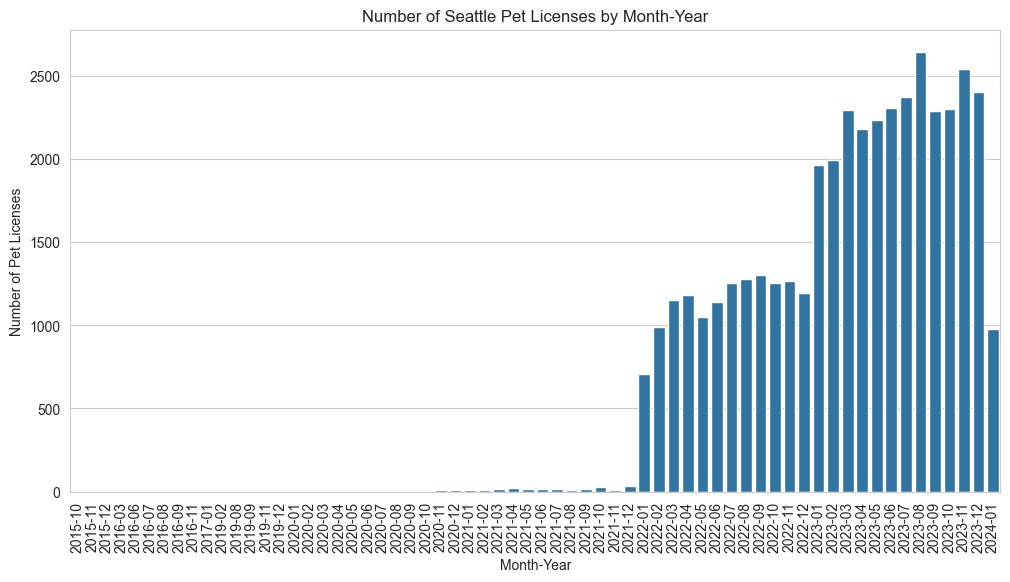

In [7]:
df_q1 = dat_clean

# Create Month-Year Variable
df_q1['MonthYear'] = df_q1['Date'].dt.to_period('M')

# Count Pet License by DateMonth
df_q1 = df_q1.groupby('MonthYear').size().reset_index(name='Count')

# Create Seaborn Bar Plot
plt.figure(figsize=(12, 6)) # Set figure size

sns.barplot(data=df_q1, x='MonthYear', y='Count', ci=True)

## Configure Titles & Axes
plt.title('Number of Seattle Pet Licenses by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Pet Licenses')
plt.xticks(rotation=90)

plt.show()

### Question 2
What day of the week are pet licenses most often granted?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\473936141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q2['Weekday'] = df_q2['Date'].dt.day_name()
C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\473936141.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_q2, x='Weekday', palette="Greens_d", order = weekday_order)


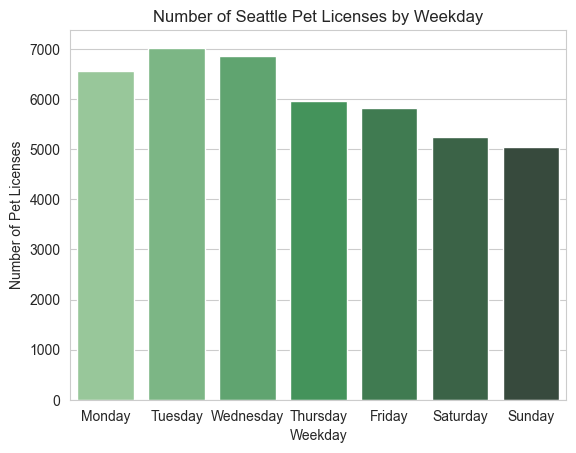

In [8]:
### MOST FREQUENT DAY (ACROSS ALL YEARS ###
df_q2 = dat_clean

# Create Weekday Variable
df_q2['Weekday'] = df_q2['Date'].dt.day_name()

# Create Seaborn Countplot
weekday_order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(data=df_q2, x='Weekday', palette="Greens_d", order = weekday_order)

## Configure Titles & Axes
plt.title('Number of Seattle Pet Licenses by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Number of Pet Licenses')

plt.show()

del weekday_order

### Question 3
What is the most popular pet species (cat, dog, goat, or pig)?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\4251148226.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dat_clean, x='Species', palette="pastel", order = ['Dog','Cat','Goat','Pig'])


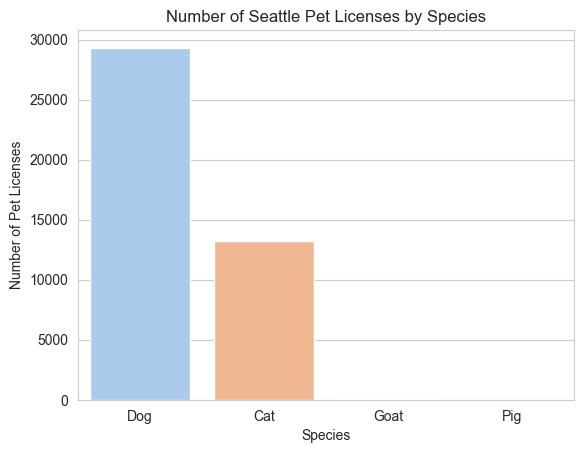

In [9]:
sns.countplot(data=dat_clean, x='Species', palette="pastel", order = ['Dog','Cat','Goat','Pig'])

## Configure Titles & Axes
plt.title('Number of Seattle Pet Licenses by Species')
plt.xlabel('Species')
plt.ylabel('Number of Pet Licenses')

plt.show()

### Question 4
What is the most popular breed (primary breed) of cats, dogs, goats, and pigs?

In [10]:
# Custom Function 
def find_top_breed(df, species, breed_type):
    """Extract the top primary/seconday breed for a species"""

    # 1) Generate Summary DF (Counts of Primary/Seconday Breeds Grouped by Species)
    top_breeds = (
        df[['Species', breed_type]]
        .groupby('Species')
        .value_counts()
        .reset_index()
    )

    # 2) Extract Top Breed by Species
    breed = (
        top_breeds
        .query('Species == @species')
        .iloc[0]
        .reset_index()
    )

    # 3
    if(breed_type == 'Primary_Breed'):
        print('The top primary breed for ' + species + ' is ' + breed.iloc[1,1] + ' with a total of ' + str(breed.iloc[2,1]) + ' Seattle pet licenses.')

    elif(breed_type == 'Secondary_Breed'):
        print('The top secondary breed for ' + species + ' is ' + breed.iloc[1,1] + ' with a total of ' + str(breed.iloc[2,1]) + ' Seattle pet licenses.')


## Loop through all Species
species = ['Cat','Dog','Goat','Pig']

# Print Top Primary Breeds
for animal in species:
    find_top_breed(df=dat_clean, species = animal, breed_type='Primary_Breed')

# Print Top Secondary Breeds
# for animal in species:
#     find_top_breed(df=dat_clean, species = animal, breed_type='Secondary_Breed')

The top primary breed for Cat is Domestic Shorthair with a total of 7302 Seattle pet licenses.
The top primary breed for Dog is Retriever, Labrador with a total of 3093 Seattle pet licenses.
The top primary breed for Goat is Miniature with a total of 21 Seattle pet licenses.
The top primary breed for Pig is Pot-Bellied with a total of 2 Seattle pet licenses.


### Question 5
What is the most popular name for cats, dogs, goats, and pigs?

In [11]:
# Count Names by Species
df_q4a = (
    dat_clean
    .groupby('Species')['Animal_Name']
    .value_counts()
    .reset_index()
)

# Extract Most Popular Names (by Species)
df_q4b = (
    dat_clean
    .groupby('Species')['Animal_Name']
    .value_counts()
    .groupby('Species')
    .idxmax()
    .apply(lambda x: x[1])
    .reset_index()
    .rename(columns = {'count':'Most_Popular_Name'})
)

# Define Custom Function to print the answer
def print_popular_name(df, species):
    """Print the most popular name for each species"""
    df_species = df.query('Species == @species')

    print('The most popular name for ' + species + 's was: ' + df_species.iloc[0,1])

for animal in species:
    print_popular_name(df=df_q4b, species = animal)


del species

The most popular name for Cats was: Luna
The most popular name for Dogs was: Luna
The most popular name for Goats was: Moppet
The most popular name for Pigs was: Calvin


### Question 6
 What Seattle zipcodes has the greatest number of pet licenses?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\3860471625.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_q6, x='Zip', y='count', order=df_q6['Zip'], palette='crest_r') # _r is reversed color order


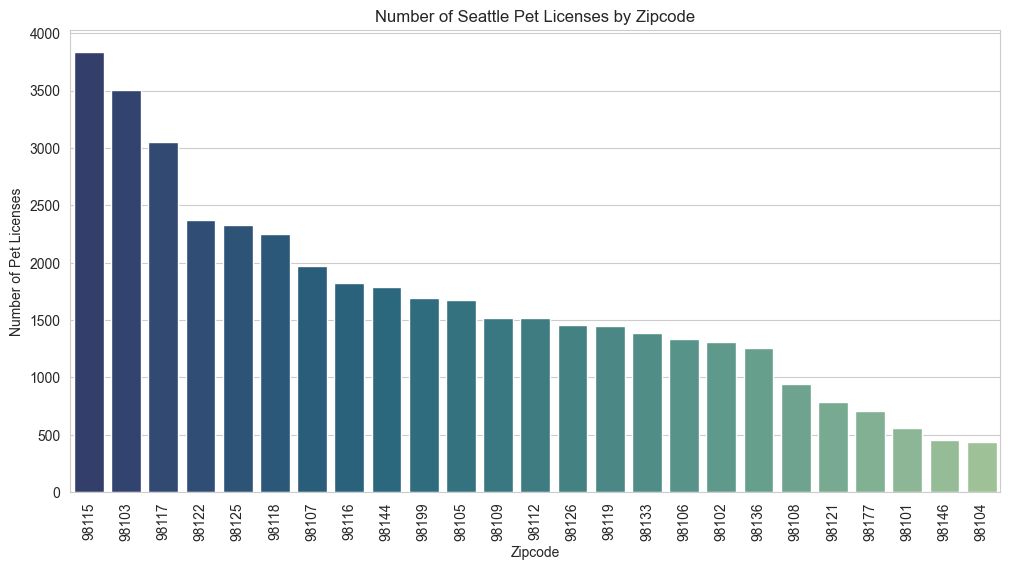

In [12]:
# Pet Licenses by Zipcode

# Calculate counts by zipcode
df_q6 = dat_clean['Zip'].value_counts().reset_index()

# Select the top 25 categories
df_q6 = df_q6.iloc[0:25,:].sort_values('count', ascending=False)

# Create the Seaborn countplot
plt.figure(figsize=(12, 6))

sns.barplot(data = df_q6, x='Zip', y='count', order=df_q6['Zip'], palette='crest_r') # _r is reversed color order
    
## Configure Titles & Axes
plt.title('Number of Seattle Pet Licenses by Zipcode')
plt.xlabel('Zipcode')
plt.ylabel('Number of Pet Licenses')
plt.xticks(rotation=90)

plt.show()

### Question 7
What Seattle zipcode(s) had the highest number of pet licenses (stratified by species)?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_38144\2788946721.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', True)` for the same effect.

  sns.barplot(data=df_q7, x='Zip', y='count', hue='Species', ci=True, order=df_q6['Zip'], hue_order = ['Dog','Cat','Goat','Pig'], palette='colorblind')


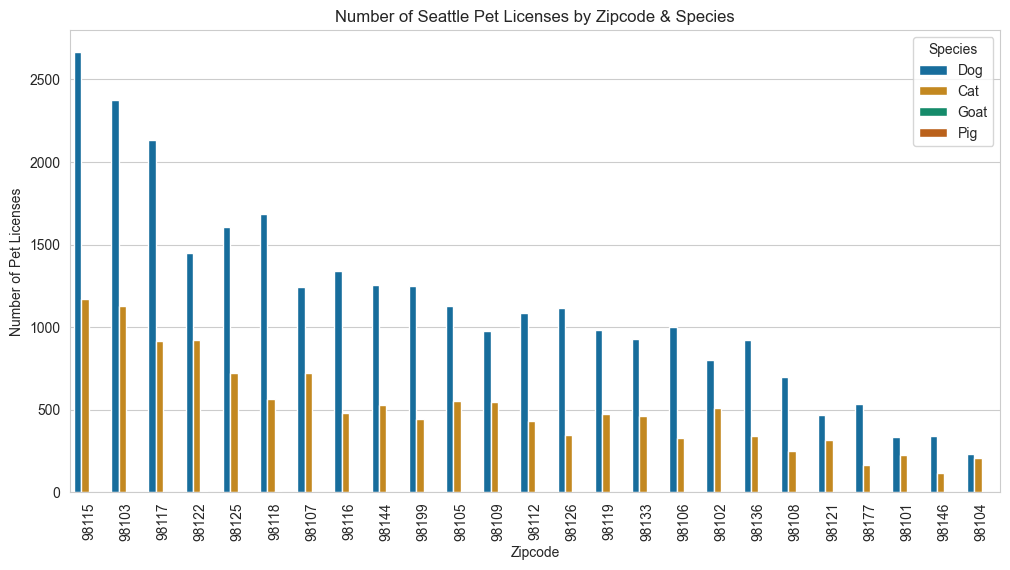

In [13]:
# Calculate counts by zipcode and species
df_q7 = (
    dat_clean
    .groupby(['Zip','Species'])
    .size()
    .reset_index(name='count')
)

# Subset all Zipcode-Species rows to the Top 25 Zipcodes (by Total Pet Licenses)
df_q7 = df_q7[df_q7['Zip'].isin(df_q6['Zip'])]

# Set the figure size
plt.figure(figsize=(12, 6))

# grouped barplot
sns.barplot(data=df_q7, x='Zip', y='count', hue='Species', ci=True, order=df_q6['Zip'], hue_order = ['Dog','Cat','Goat','Pig'], palette='colorblind')

## Configure Titles & Axes
plt.title('Number of Seattle Pet Licenses by Zipcode & Species')
plt.xlabel('Zipcode')
plt.ylabel('Number of Pet Licenses')
plt.xticks(rotation=90)

plt.show()